<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2019 </h1>

<H3 align='center'> Tarea 3 - Ensamblados y modelos avanzados </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Técnicas de ensamblado: *bagging*, *boosting* y *random forest*.
* Ventajas de técnicas de ensamblados
* Problemas desbalanceados
 

**Formalidades**  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y cierre competencia: 17 de Enero
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF393-II-2019]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Ensamblados para regresión  
[2.](#segundo) Detección de acoso en *Twitter*  

<a id="segundo"></a>
## 2. Detección de acoso en *Twitter*
---
En las redes sociales muchas veces se encuentra con un cierto comportamiento indeseable para los usuarios, tal como racismo, misógeno, grupos de odio o *trolls*. El poder detectar de manera automática ciertos patrones en el comportamiento para tomar una acción debe ser crucial para reducir el tiempo y esfuerzo humano. En esta actividad se trabajará sobre *tweets* la red social de *twitter* para detectar comportamiento *online* de acoso (*harassment*), que por lo general, incluye *flaming* como lenguaje abusivo o insultos, *doxing* como mostrar la información personal de una mujer, por ejemplo el domicilio o número de teléfono, la suplantación o la vergüenza pública por destruir la reputación de las personas.

<img src="https://kidshelpline.com.au/sites/default/files/bdl_image/header-T-OH.png" title="Title text" width="45%"  />

En algunos problemas como este, el comportamiento a detectar puede ser asociado a una anomalía (*outlier*) del comportamiento normal de los usuarios en las redes sociales. Esto es una de las causas de la dificultad del problema, puesto que es **altamente desbalanceado**, donde aproximadamente un 10% de los *tweets* corresponden a acoso (*harassment*).

Los datos trabajados corresponderan a *tweets* etiquetados como *harassment* (con valor 1) o no (con valor 0) -- la tarea a detectar--. Además si desea utilizar, se incluye la información del tipo de *harassment* en el conjunto de entrenamiento como atributos extras. El conjunto de pruebas solo contiene los *tweets* a ser etiquetados.

---
### Importante
* Esta pregunta será evaluada **sólo** por los resultados (*submission*) obtenidos en el desafío presentado en __[Kaggle](https://www.kaggle.com/c/t1-ml/)__ a través del siguiente __[link](https://www.kaggle.com/t/91f8c0c746f945cfa510b88469df4d67)__. Las notas serán entregadas a través de la siguiente fórmula:  
$$ Nota(i) = 100\cdot max\left(0.55; s^{(1-i)} \right), \ \ con \ \ i \in \{1,\ \ldots, N\}$$
Con la escala de decaimiento es $ s = 1.05$ y con $i$ su lugar en el *ranking*.

* La métrica de evaluación será el *f1 score* [[3]](#refs) sobre la clase positiva (*harassment*), así evaluar la calidad del modelo sobre la clase minoritaria, lo cual también debiera reflejar el desempeño de la clase negativa (al ser el complemento).
```python
from  sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='binary')
```

* El archivo de *submission* debe contener las predicciones de *harassment* (0 o 1) a cada dato de pruebas, además de la columna de *id* asociado al dato, iniciando en 1. Si leyó de manera ordenada el archivo de pruebas, se puede generar de la siguiente manera:
```python
df_aux = pd.DataFrame()
df_aux["id"] = np.arange(1, 1+y_pred.shape[0])
df_aux["harassment"] = y_pred.astype('int')
df_aux.to_csv("test_estimation.csv", index=False)
```

* Se solicita realizar **un solo** *submission* por grupo, para no perjudicar la nota de sus compañeros en el *ranking*. Además de ser claros con sus nombres de entrega para no asignarles de manera errónea su correspondiente nota.

* **Si no realiza *submission* a Kaggle su nota en esta sección será de 0**.

* **Si su *score* alcanzado es menor o igual al *benchmark* random que se encuentra en el *ranking*, su nota en esta sección será de 25**

In [87]:
import nltk
import pandas as pd
import numpy as np
import re, time
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from  sklearn.metrics import f1_score

In [24]:
#Primero se lee el archivo

df_train_original = pd.read_csv('Train_data.csv', index_col = 0)

In [25]:
df_train_original.head()

,tweet_content,harassment,IndirectH,PhysicalH,SexualH
id,,,,,
9565,also released this video of photos voyager too...,0,0,0,0
6794,Yeah sexting older games until x89 teach doug...,0,0,0,0
4337,ava There s likely hundreds of stories like t...,0,0,0,0
6621,Wonder if there is significance to having Ava ...,0,0,0,0
3289,i m a slut for guacamole an avocadhoe if you will,0,0,0,0


In [26]:
df_train_original.sum()

tweet_content    also released this video of photos voyager too...
harassment                                                     549
IndirectH                                                      126
PhysicalH                                                      112
SexualH                                                        311
dtype: object

In [27]:
df_train_original.count()

tweet_content    5703
harassment       5703
IndirectH        5703
PhysicalH        5703
SexualH          5703
dtype: int64

In [28]:
#porcentaje de haressment
5703/549

10.387978142076502

Se separan los datos en entrenamiento y de evaluacion

In [30]:
np.random.seed(0)
mask_test = np.random.rand(df_train_original.shape[0]) < 0.20

df_train = df_train_original['tweet_content'][~mask_test] 
df_val= df_train_original['tweet_content'][mask_test]

labels_train_harassment = df_train_original['harassment'][~mask_test]
labels_val_harassment = df_train_original['harassment'][mask_test]

labels_train_harassment = df_train_original['IndirectH'][~mask_test]
labels_val_harassment = df_train_original['IndirectH'][mask_test]

labels_train_harassment = df_train_original['PhysicalH'][~mask_test]
labels_val_harassment = df_train_original['PhysicalH'][mask_test]

labels_train_harassment = df_train_original['SexualH'][~mask_test]
labels_val_harassment = df_train_original['SexualH'][mask_test]

print("Cantidad de datos de entrenamiento:", df_train_original.shape[0])
print("Cantidad de datos de evaluacion", df_val.shape[0])

Cantidad de datos de entrenamiento: 5703
Cantidad de datos de evaluacion 1149


Se realizará una matriz de frecuencia

In [33]:
#letamtizar textos
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arjon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arjon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arjon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [43]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
def base_word(word):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word) 
def word_extractor(text):
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text) #substitute multiple letter by two
    words = ""
    wordtokens = [ base_word(word.lower()) for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords: #delete stopwords
            words+=" "+word
    return words

texts_train = [word_extractor(text) for text in df_train]
texts_train_original = [word_extractor(text) for text in df_train_original]
texts_val = [word_extractor(text) for text in df_val]

In [41]:
df_train.head()

id
9565    also released this video of photos voyager too...
6794     Yeah sexting older games until x89 teach doug...
4337     ava There s likely hundreds of stories like t...
6621    Wonder if there is significance to having Ava ...
3289    i m a slut for guacamole an avocadhoe if you will
Name: tweet_content, dtype: object

In [40]:
#Transformar los textos en vectores
EMBEDDING_DIM = 300
GLOVE_FILE = "./glove.6B.%dd.txt"%(EMBEDDING_DIM)
embeddings_index = {}
with open(GLOVE_FILE,encoding="utf8") as file:
    for line in file:
        values = line.split()
        embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

#vocab = vectorizer.get_feature_names()
#embeddings_index.get(word)

In [48]:
#se crea el vocabulario de las palabras en texts_train
def get_vocab(texts):
    vocab = []
    for text in texts:
        for word in text.strip().split():
            if word in [".",",","'s","'","-","_"]:
                continue
            if word not in vocab:
                vocab.append(word)
    return vocab

vocab_train_haressment = get_vocab(texts_train)
vocab_train = get_vocab(texts_train)

In [53]:
#se crea un vocabulario especial de los tweets haressment
contador = 0
texts_train_harassment=[]
for i in labels_train_harassment:
    if i == 1:
        texts_train_harassment.append(texts_train[contador])
    contador+=1
vocab_train_haressment = get_vocab(texts_train_harassment)

In [55]:
#acotar embeddings_index por el vocabulario
embeddings_index_in_vocab = {}
for word in vocab_train:
    if word in embeddings_index:
        embeddings_index_in_vocab[word] = embeddings_index.get(word)

In [56]:

#sp.sparse.csr_matrix((3, 4), dtype=np.int8).toarray()

def transform(vocab,texts):
    index_find_previously = {}
    rows = []
    cols = []
    datas = []
    new_matrix = sp.sparse.csr_matrix((len(texts), len(vocab)), dtype=np.float64)
    for row in range(len(texts)):
        data_temp = {}
        for word in texts[row].strip().split():
            if word in [".",",","'s","'","-","_"]:
                continue
            if word in vocab:
                if vocab.index(word) in data_temp:
                    data_temp[vocab.index(word)] +=1
                else:
                    data_temp[vocab.index(word)] = 1
            elif word in embeddings_index:
                if word not in index_find_previously:
                    index_find = find_closest_embeddings(vocab,word)
                    index_find_previously[word] = index_find
                else:
                    index_find = index_find_previously[word]
                
                if index_find == -1:
                    continue
                
                if index_find in data_temp:
                    data_temp[index_find] +=1
                else:
                    data_temp[index_find] = 1
        for col,data in data_temp.items():
            rows.append(row)
            cols.append(col)
            datas.append(data)
    return sp.sparse.csr_matrix((datas, (rows, cols)), shape=(len(texts), len(vocab)))

import heapq
def find_closest_embeddings(vocab,word_search):
    words_find = heapq.nsmallest(2,embeddings_index_in_vocab.keys(),key=lambda word: sp.spatial.distance.euclidean(embeddings_index_in_vocab.get(word),embeddings_index.get(word_search)))
    for word in words_find:
        if word in vocab:
            #print("encontro",word)
            return vocab.index(word)
    #"no se encontro ninguna palabra parecida a word_search
    return -1


In [61]:
features_train = transform(vocab_train,texts_train)
print("termino features_train")
features_val = transform(vocab_train,texts_val)
print("termino features_val")
#features_test = transform(vocab,texts_test)
#print("termino features_test")


termino features_train
termino features_val


NameError: name 'vocab' is not defined

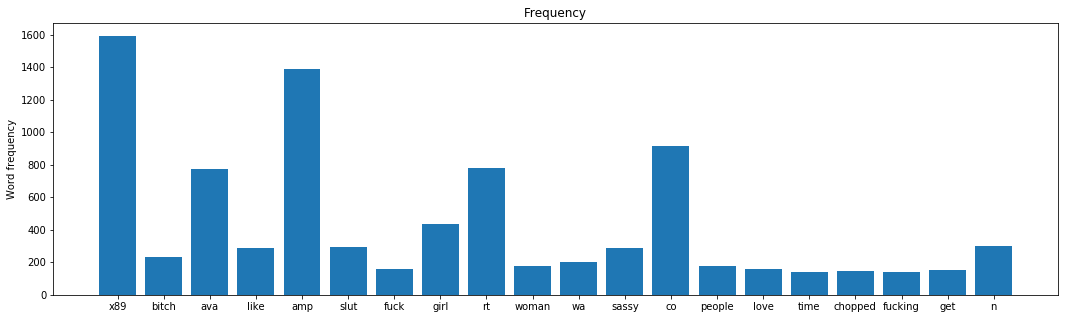

In [64]:
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))

sorted_dist = sorted(dist)

top_20_most_freq_words = []
top_20_most_freq_dist = []

for i in range(len(dist)):

    if dist[i] >= sorted_dist[-20]:
        
        top_20_most_freq_words.append(vocab_train[i])
        top_20_most_freq_dist.append(dist[i])

objects = top_20_most_freq_words
y_pos = np.arange(len(top_20_most_freq_words))
performance = top_20_most_freq_dist

f, ax = plt.subplots(figsize=(18,5))
plt.bar(y_pos, performance, align='center')
plt.xticks(y_pos, objects)
plt.ylabel('Word frequency')
plt.title('Frequency')

plt.show()

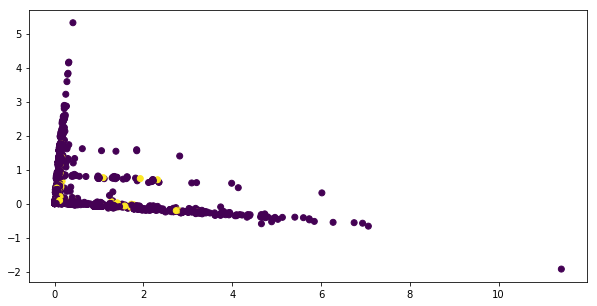

In [67]:
from sklearn.decomposition import TruncatedSVD
model = TruncatedSVD(n_components=2)
model.fit(features_train)
x_plot = model.transform(features_train)

plt.figure(figsize=(10,5))
plt.scatter(x_plot[:,0], x_plot[:,1], c=labels_train_harassment)
plt.show()

In [96]:
def mostrar_resultados(y_test, pred_y):
    print(f1_score(y_test, pred_y, average='binary'))
def do_model(model_function, parameters_range, plot_title, x_axis_name):
    list_f1 = []
    for parameter in parameters_range:
        model, y_test, pred_y = model_function(features_train,labels_train_harassment,features_val,labels_val_harassment, param = parameter)
        list_f1.append(f1_score(y_test, pred_y, average='binary'))
    plt.figure(figsize=(10,5))
    plt.title(plot_title)
    plt.plot(parameters_range, list_f1)
    plt.ylabel('f1')
    plt.xlabel(x_axis_name)
    plt.show()
    return

In [70]:
print(features_train.shape,
labels_train_harassment.shape,
features_val.shape,
labels_val_harassment.shape)

(4554, 12885) (4554,) (1149, 12885) (1149,)


Primero se hará regresión lineal sin contar el peso, para tener un estandar

D:\Programas\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programas\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programas\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


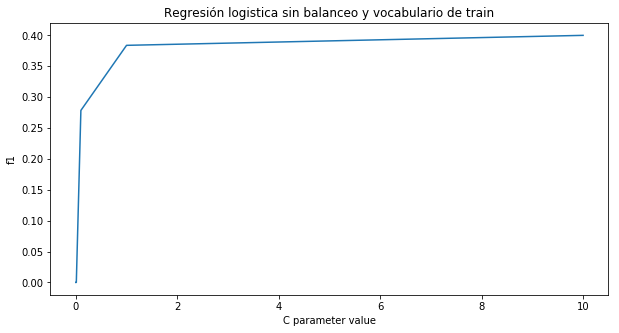

In [98]:
from sklearn.linear_model import LogisticRegression

def do_LOGIT(x,y,xv,yv, param):
    #print("Param C = ",param)
    model= LogisticRegression()
    model.set_params(C = param)
    model.fit(x,y)
    pred_y = model.predict(xv)
    return model, yv, pred_y

do_model(do_LOGIT, [10**-4,10**-3,10**-2,10**-1,10**0,10**1], "Regresión logistica sin balanceo y vocabulario de train", 'C parameter value')

<a id="refs"></a>
## Referencias
[1] https://scikit-learn.org/stable/modules/ensemble.html  
[2] https://scikit-learn.org/stable/modules/tree.html  
[3] http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  
[4] https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18